In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/iritani/.pyenv/versions/anaconda3-2020.07/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['xlim', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [50]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.optimize
import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

from scipy.interpolate import InterpolatedUnivariateSpline


import json
import os
import glob

import sys
sys.path.append('../src')
from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

# load data

In [4]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

Label  N_f  beta     kappa  size_L  size_T bdy.cond.  a [fm]  m_pi [MeV]  \
0  N300    3  3.70  0.137000      48     128      open  0.0498         422   
1  N202    3  3.55  0.137000      48     128      open  0.0642         412   
2  H200    3  3.55  0.137000      32      96      open  0.0642         419   
3  B450    3  3.46  0.136890      32      64  periodic  0.0762         417   
4  H101    3  3.40  0.136760      32      96      open  0.0865         417   
5  U103    3  3.40  0.136760      24     128      open  0.0865         414   
6  A653    3  3.34  0.136572      24      48  periodic  0.0992         424   
7    E5    2  5.30  0.136250      32      64  periodic  0.0658         436   
8    E1    2  5.30  0.135500      32      64  periodic  0.0658         978   

   L [fm]  m_pi L  m_B [GeV]  N_conf  N_tsrc  N_meas  N_LapH  a2 [fm2]  \
0     2.4     5.1       1.19    2047      12   24564      32  0.002480   
1     3.1     6.4       1.17     899       8   10788      68  0.004122   
2     2.1     4.4       1.19    2000       8   16000      20  0.004122   
3     2.4     5.2       1.18    1612       8   25762      32  0.005806   
4     2.8     5.9       1.16    2016       4   12096      48  0.007482   
5     2.1     4.4       1.18    5658       5   45264      20  0.007482   
6     2.4     5.1       1.16    5050       4   40400      32  0.009841   
7     2.1     4.7       1.29    2000       4   16000      30  0.004330   
8     2.1    10.4       2.03     168       8    2688      30  0.004330   

   a_inv [GeV]  
0        3.962  
1        3.074  
2        3.074  
3        2.590  
4        2.281  
5        2.281  
6        1.989  
7        2.999  
8        2.999

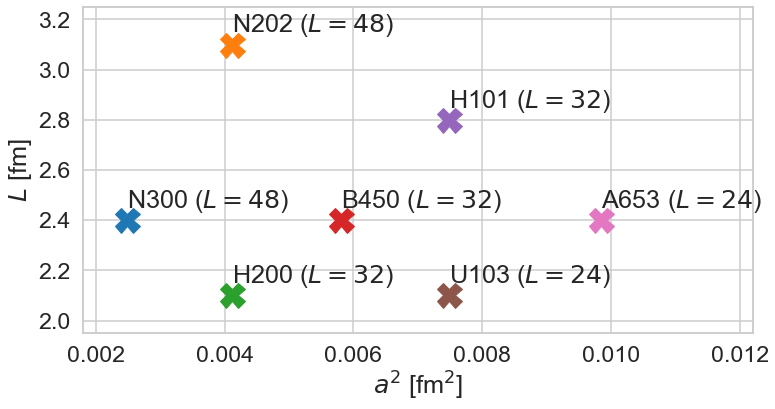

In [5]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))
#    fig.savefig('../figs/SU3_ensembles.png', bbox_inches='tight')

In [6]:
ls ../data/pcot_p2/

A653_P000_0_spin_zero.json  H101_P011_0_spin_zero.json
A653_P000_1_spin_zero.json  H101_P011_1_spin_zero.json
A653_P001_0_spin_zero.json  H101_P111_0_spin_zero.json
A653_P001_1_spin_zero.json  H101_P111_1_spin_zero.json
A653_P002_0_spin_zero.json  H200_P000_0_spin_zero.json
A653_P011_0_spin_zero.json  H200_P000_1_spin_zero.json
A653_P011_1_spin_zero.json  H200_P001_0_spin_zero.json
A653_P111_0_spin_zero.json  H200_P001_1_spin_zero.json
A653_P111_1_spin_zero.json  H200_P002_0_spin_zero.json
B450_P000_0_spin_zero.json  H200_P011_0_spin_zero.json
B450_P000_1_spin_zero.json  H200_P011_1_spin_zero.json
B450_P001_0_spin_zero.json  H200_P111_0_spin_zero.json
B450_P001_1_spin_zero.json  H200_P111_1_spin_zero.json
B450_P002_0_spin_zero.json  N202_P000_0_spin_zero.json
B450_P011_0_spin_zero.json  N202_P000_1_spin_zero.json
B450_P011_1_spin_zero.json  N202_P001_0_spin_zero.json
B450_P111_0_spin_zero.json  N202_P001_1_spin_zero.json
B450_P111_1_spin_zero.json  N202_P002_0_spin_zero.json
E1_P000_0_

In [7]:
ld_dic = {}
for fname in glob.glob('../data/pcot_p2/*.json'):
    with open(fname, 'r') as fin:
        tmp = json.load(fin)
        ld_dic[(tmp.get('label'), tmp.get('frame'), tmp.get('level'))] = tmp

# plot

In [11]:
xlim0 = (-0.8, 2.5)
ylim0 = (-0.9, 4.9)


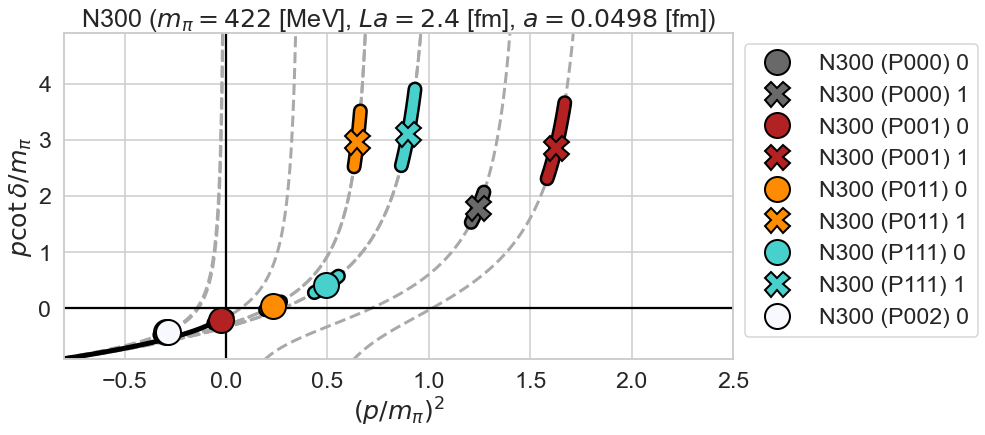

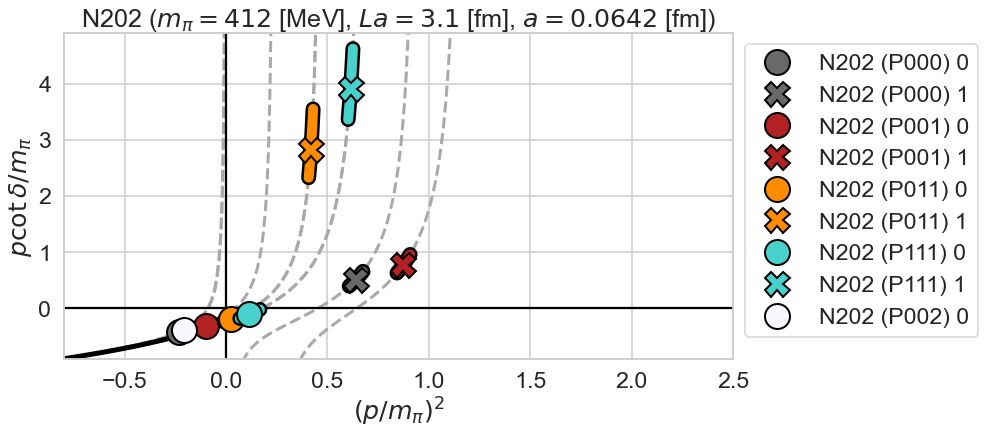

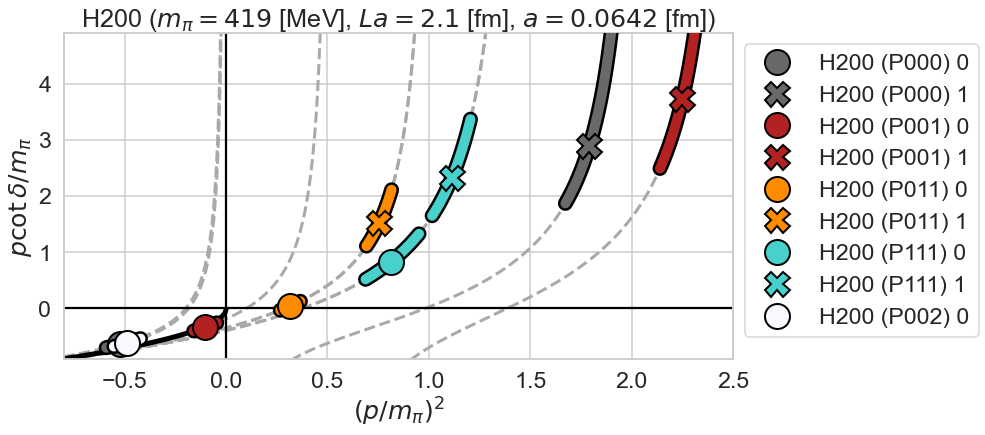

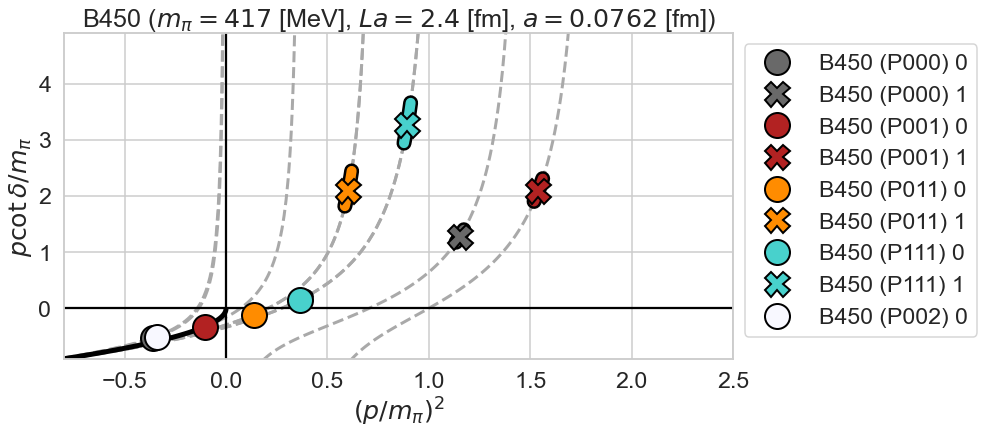

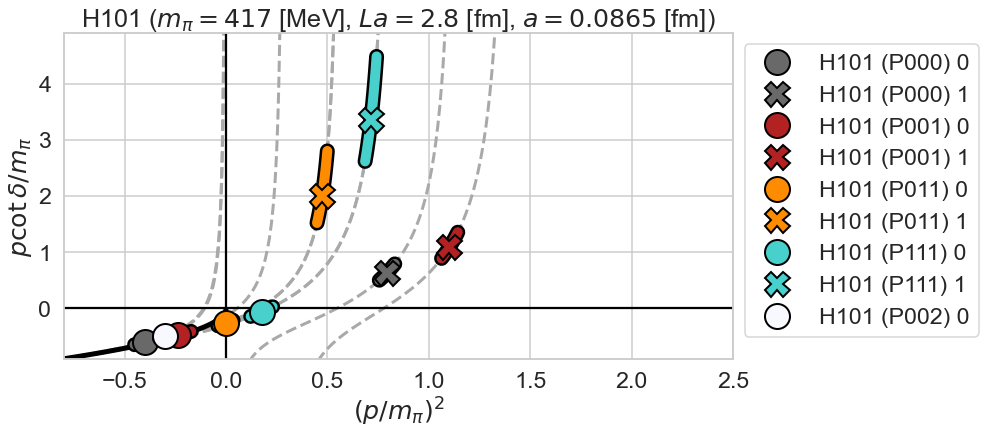

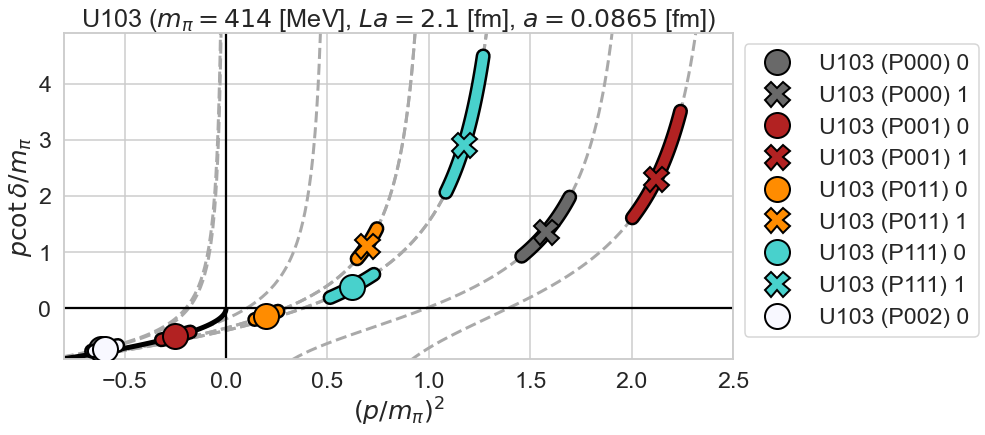

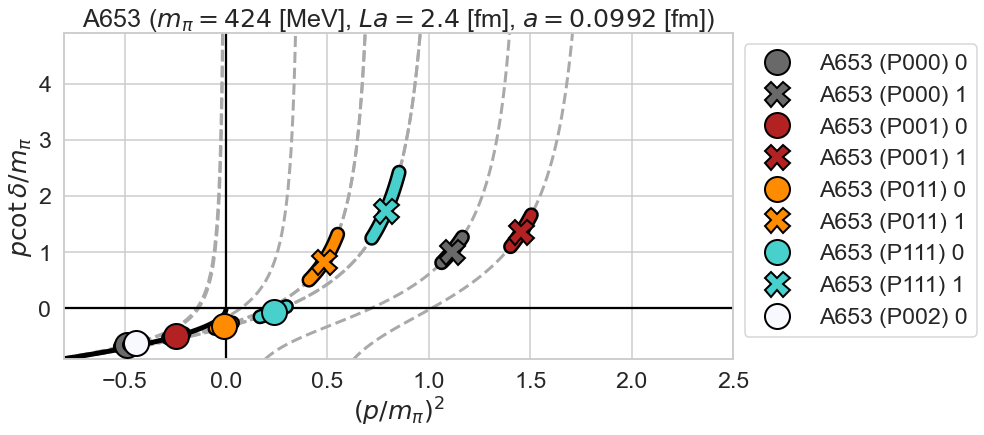

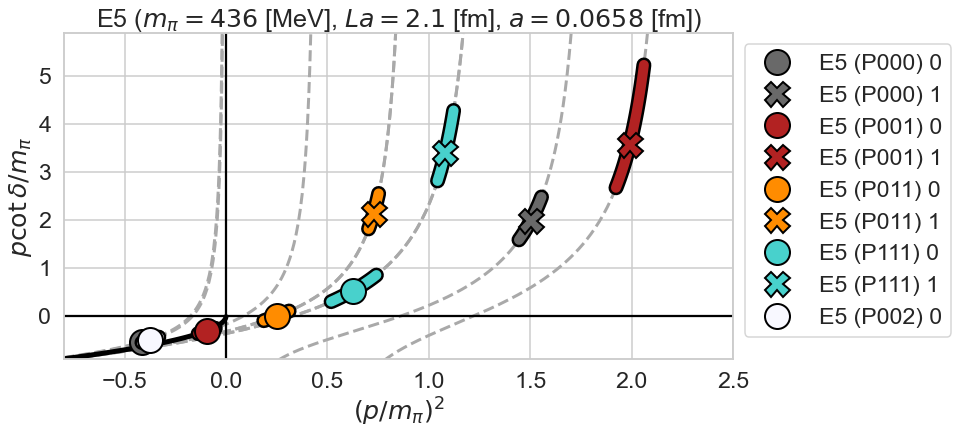

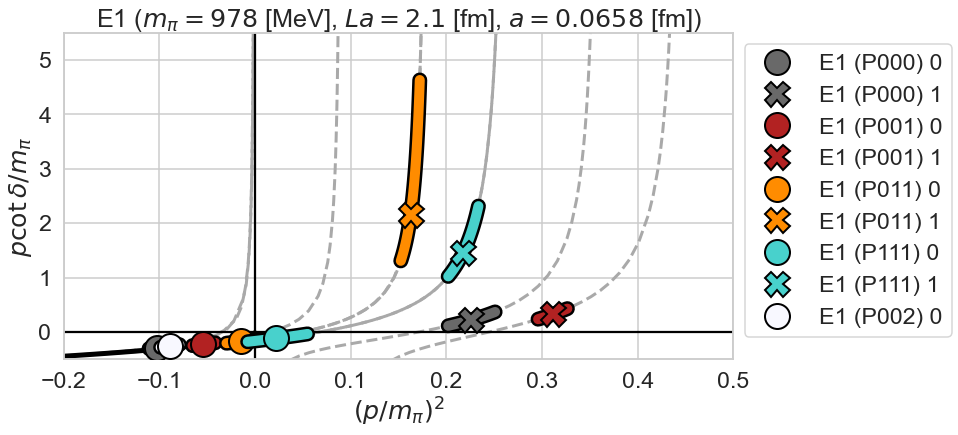

In [8]:
xlim, ylim = xlim0, ylim0

color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

for label in ['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']:
    if label == 'E1':
        xlim, ylim = (-0.2, 0.5), (-0.5, 5.5)
    if label == 'E5':
        xlim, ylim = (-0.8, 2.5), (-0.9, 5.9)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass
            
    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')
    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2.png', bbox_inches='tight') # , transparent=True)

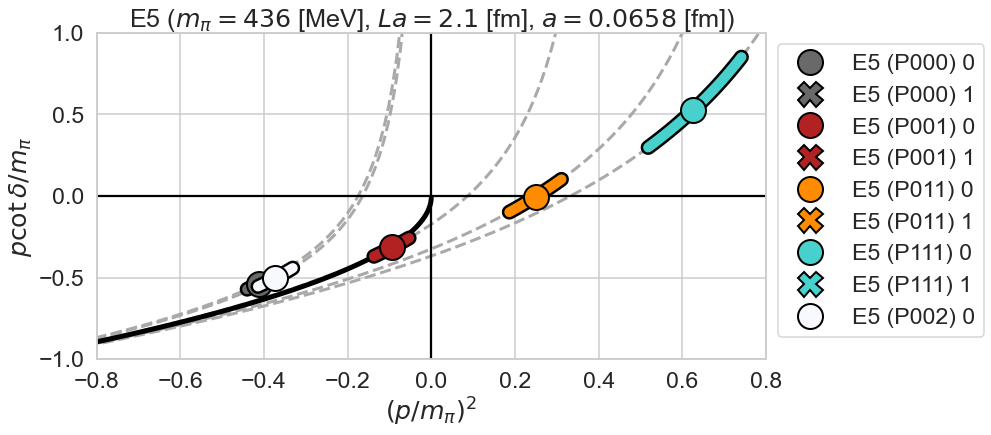

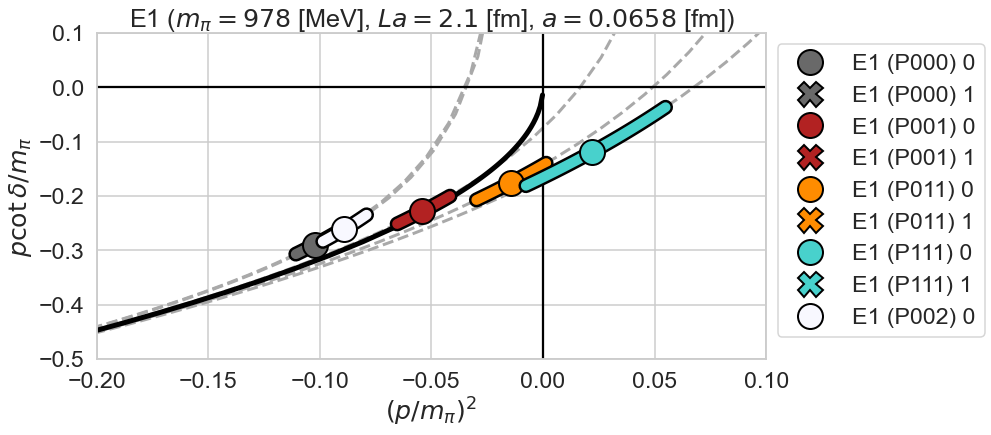

In [9]:
xlim, ylim = (-0.8, 0.4), (-0.9, 0.4)

color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

for label in ['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']:
    if label == 'E1':
        xlim, ylim = (-0.2, 0.1), (-0.5, 0.1)
    elif label == 'E5':
        xlim, ylim = (-0.8, 0.8), (-1, 1)
    else:
        continue

    
    fig, ax = plt.subplots(figsize=(12,6))

    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
                if level == 0:
                    ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass
            
    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')
    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2_neg.png', bbox_inches='tight') # , transparent=True)

In [243]:
def plotly_pcot_vs_p2(label, xlim, ylim):
    fig = go.Figure()

    color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1,-2e-4)])


    fig.add_hline(y=0, line_width=3)
    fig.add_vline(x=0, line_width=3)

    fig.add_trace(
        go.Scatter(x=xbs, y=-np.sqrt(-xbs), mode='lines',
                  line=dict(color='black', width=5), name='bound state condition', showlegend=False)
    )


    for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                sym={0:'circle', 1:'x', 2:'triangle-up'}[level]

                lbl = f'{label} ({frame}) n={level}'

                if (level == 1) and (frame in ['P011', 'P111']):
                    pass
                else:
                    fig.add_traces(
                        [
                            go.Scatter(x=ld.get('k2mpi2_ref'), y=ld.get('kcot_mpi_ref'), mode='lines',
                                        line=dict(dash='dash', color='gray', width=2), legendgroup=lbl, name='FV constraints', showlegend=False,
                                       hovertemplate='(%{x:.3f}, %{y:.3f})'
                                      )])
                fig.add_traces(
                    [
                        go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                  line=dict(color='black', width=12), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                  line=dict(color=c, width=8), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=[ld.get('k2mpi2')], y=[ld.get('kcot_mpi')], mode='markers',
                                   hovertemplate=lbl+'<br>(%{x:.3f}, %{y:.3f})', showlegend=True,
                                    marker=dict(color=c, size=25, symbol=sym,
                                               line=dict(width=2, color='black')), legendgroup=lbl, name=lbl)
                    ]
                )
            except:
                pass #print(label, frame, level)



    fig.update_layout(
        title=f'$\LARGE{{\mathrm{{{label}}} \ (m_\pi = {pion_mass_dic.get(label)} \ [\mathrm{{MeV}}], \ La = {L_fm_dic.get(label)} \ [\mathrm{{fm}}], a = {lat_unit_dic.get(label)} \ [\mathrm{{fm}}])}}$',
        xaxis_title='$\LARGE{(p/m_\pi)^2}$', 
                     yaxis_title='$\LARGE{p\cot\delta/m_\pi}$',
                     xaxis_range=xlim, yaxis_range=ylim,
                     font=dict(size=32))
    fig.write_html(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2.html', include_mathjax='cdn', include_plotlyjs='cdn')
    return fig

In [244]:
label_list

['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']

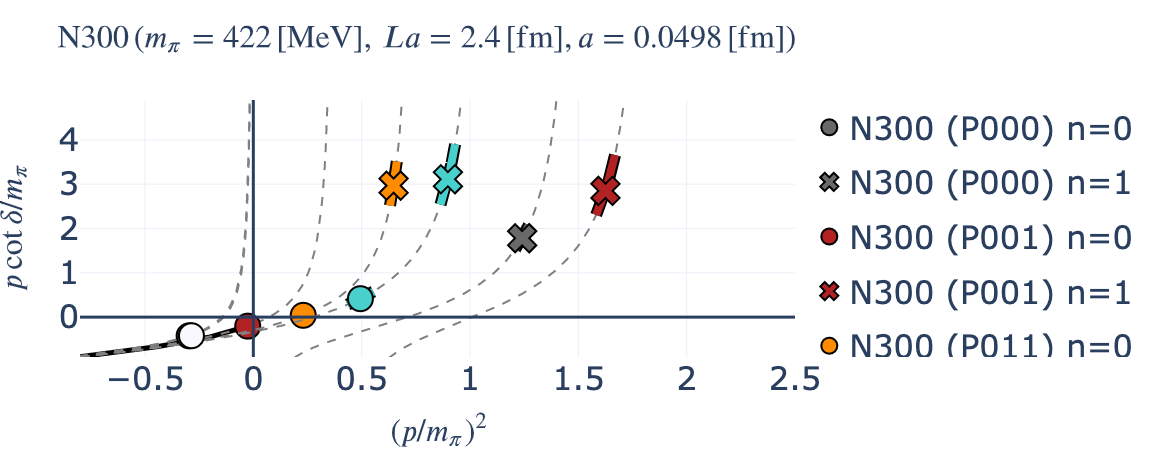

In [245]:
plotly_pcot_vs_p2('N300', xlim0, ylim0)

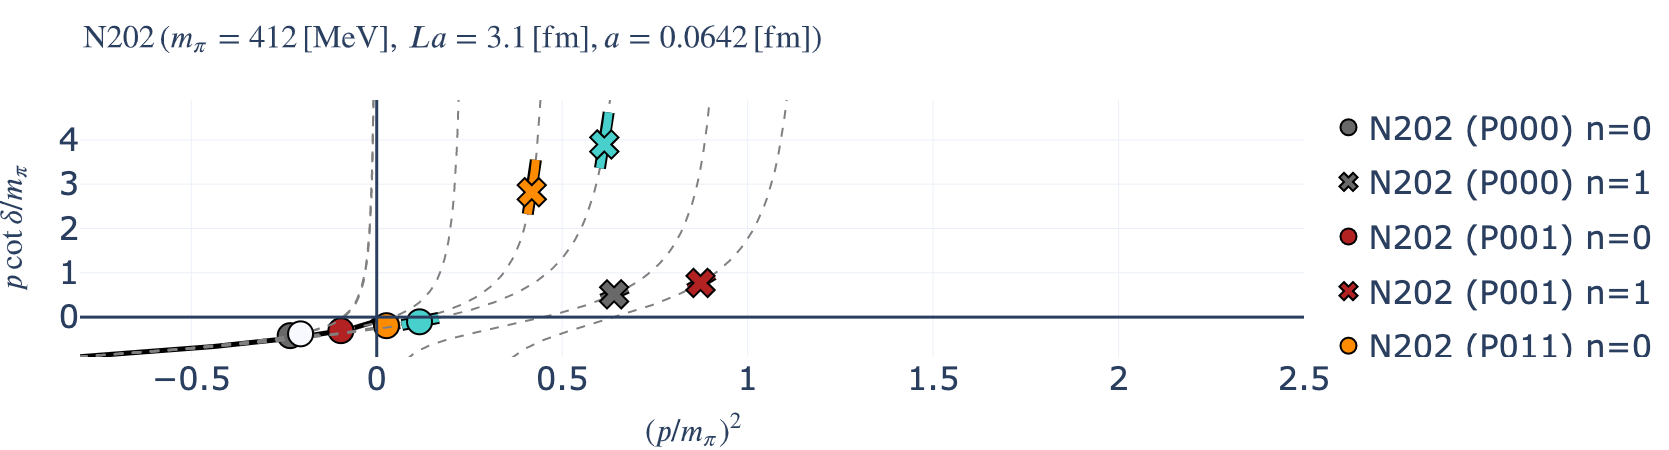

In [13]:
plotly_pcot_vs_p2('N202', xlim0, ylim0)

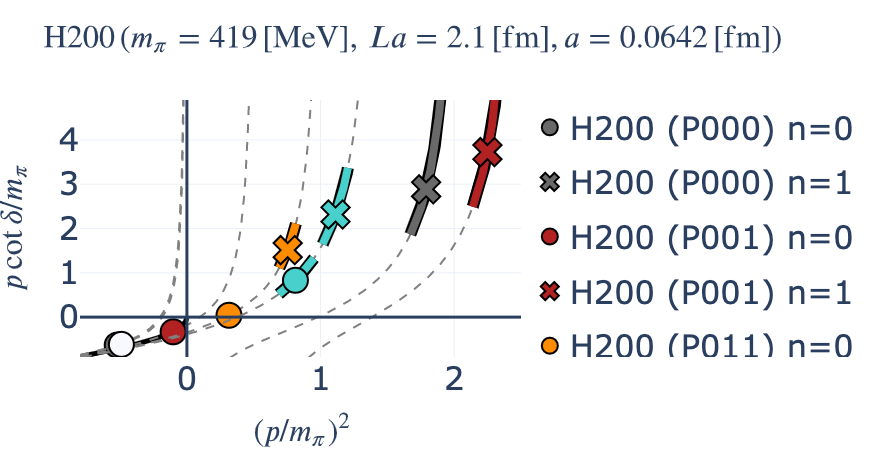

In [14]:
plotly_pcot_vs_p2('H200', xlim0, ylim0)

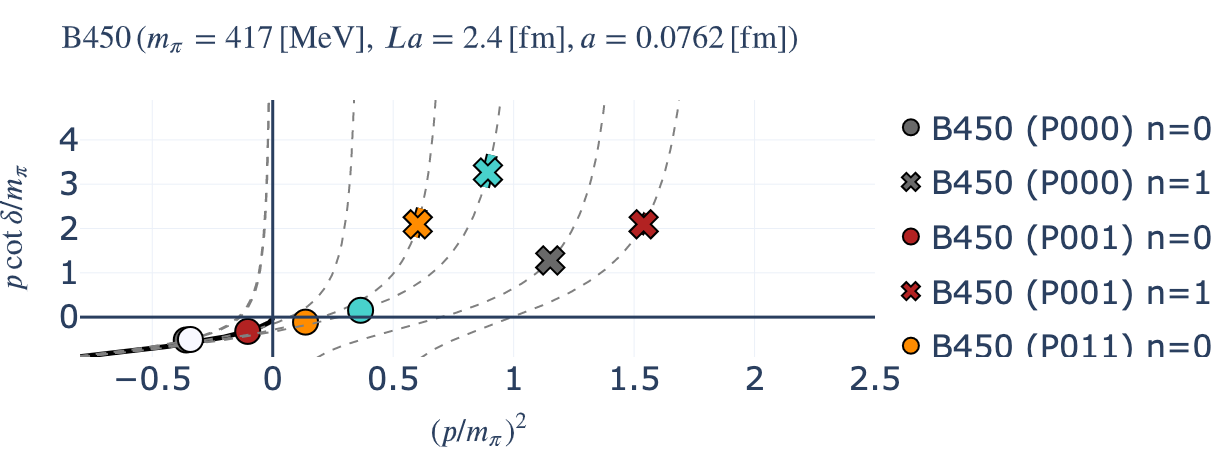

In [15]:
plotly_pcot_vs_p2('B450', xlim0, ylim0)

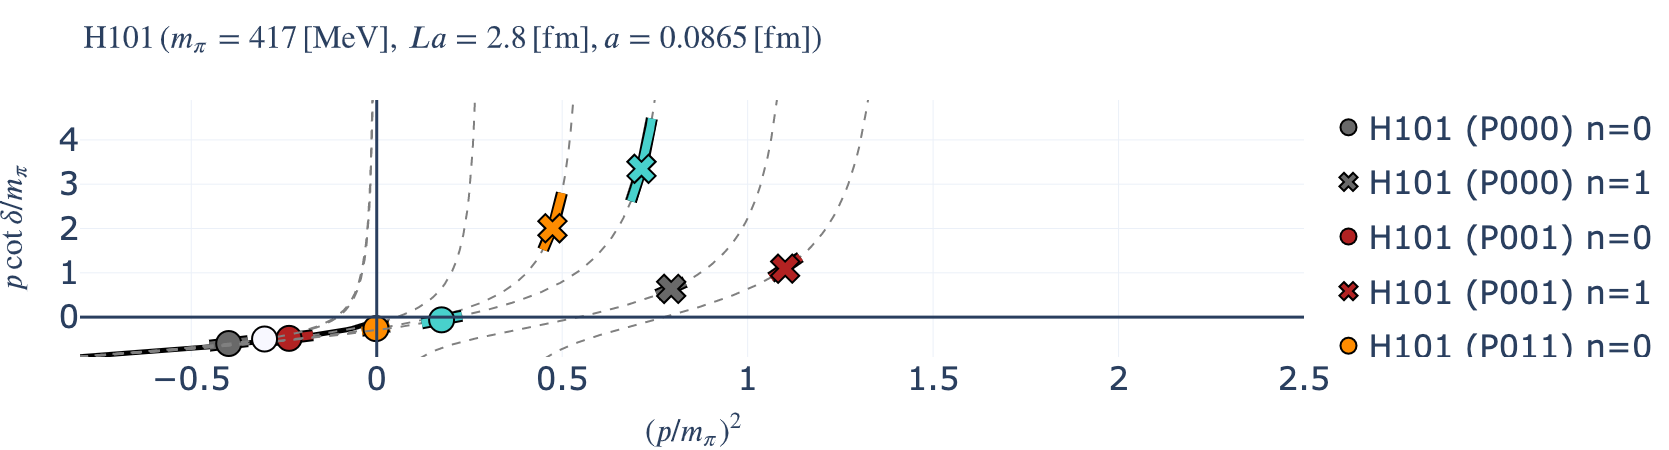

In [16]:
plotly_pcot_vs_p2('H101', xlim0, ylim0)

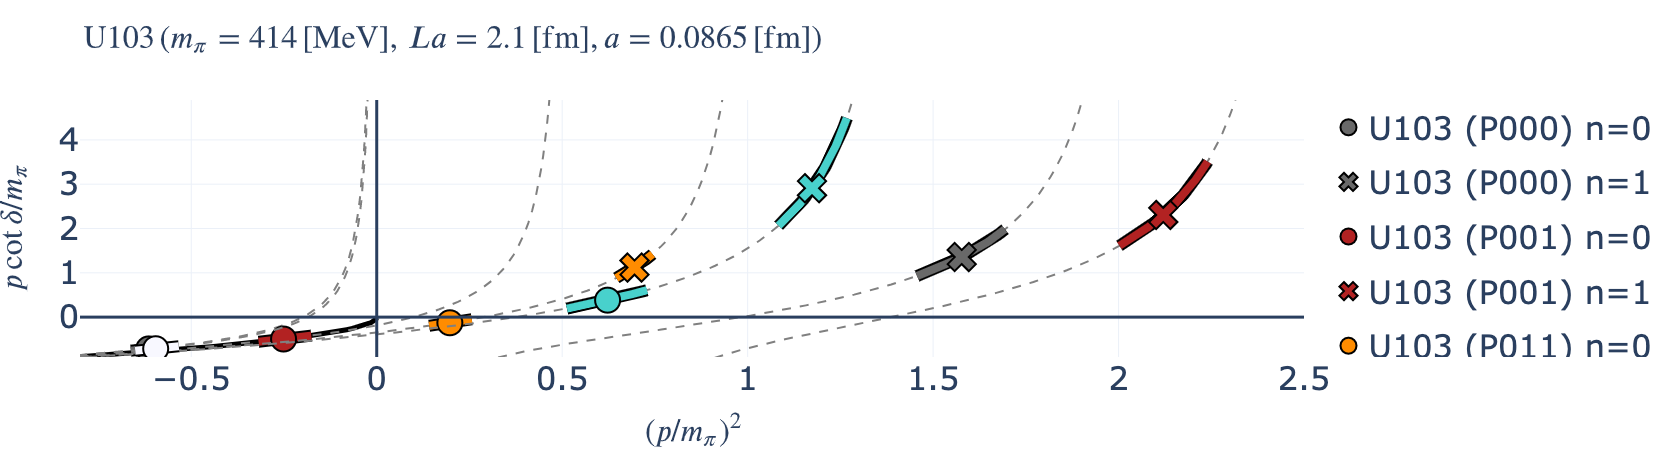

In [17]:
plotly_pcot_vs_p2('U103', xlim0, ylim0)

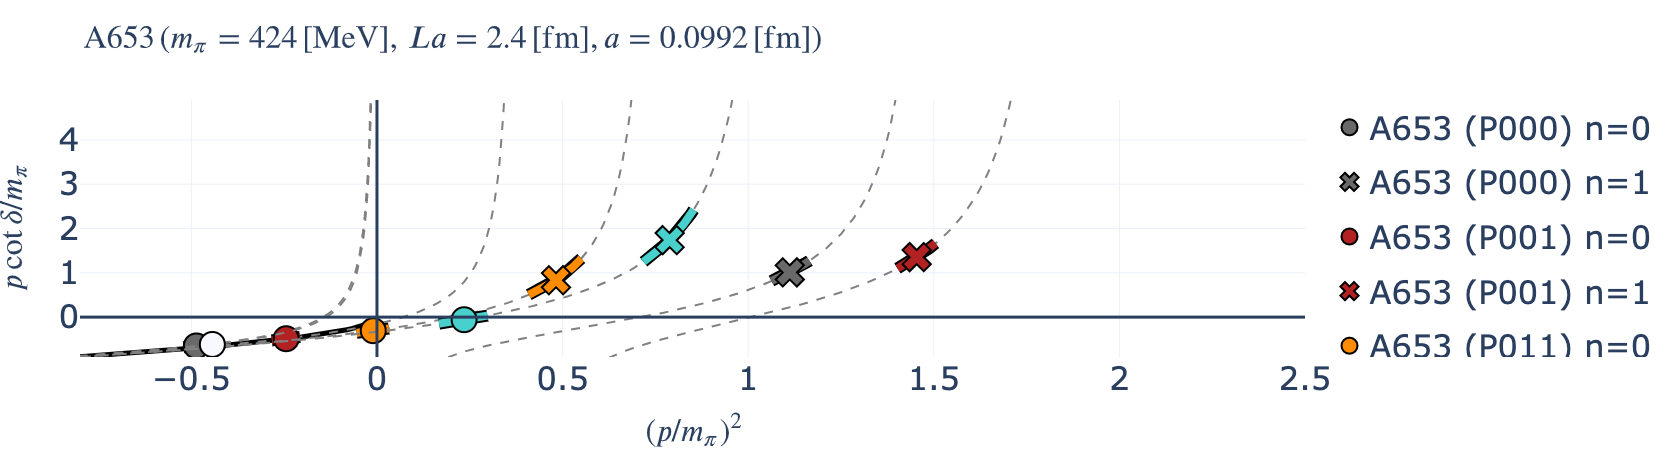

In [18]:
plotly_pcot_vs_p2('A653', xlim0, ylim0)

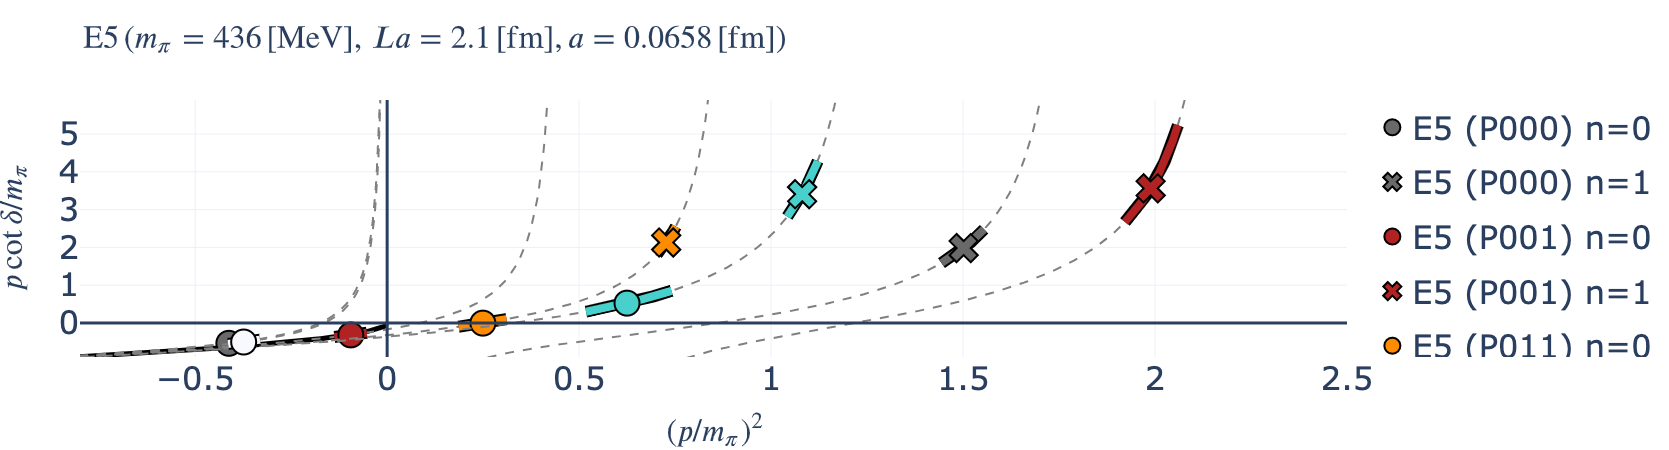

In [19]:
plotly_pcot_vs_p2('E5', (-0.8, 2.5), (-0.9, 5.9))

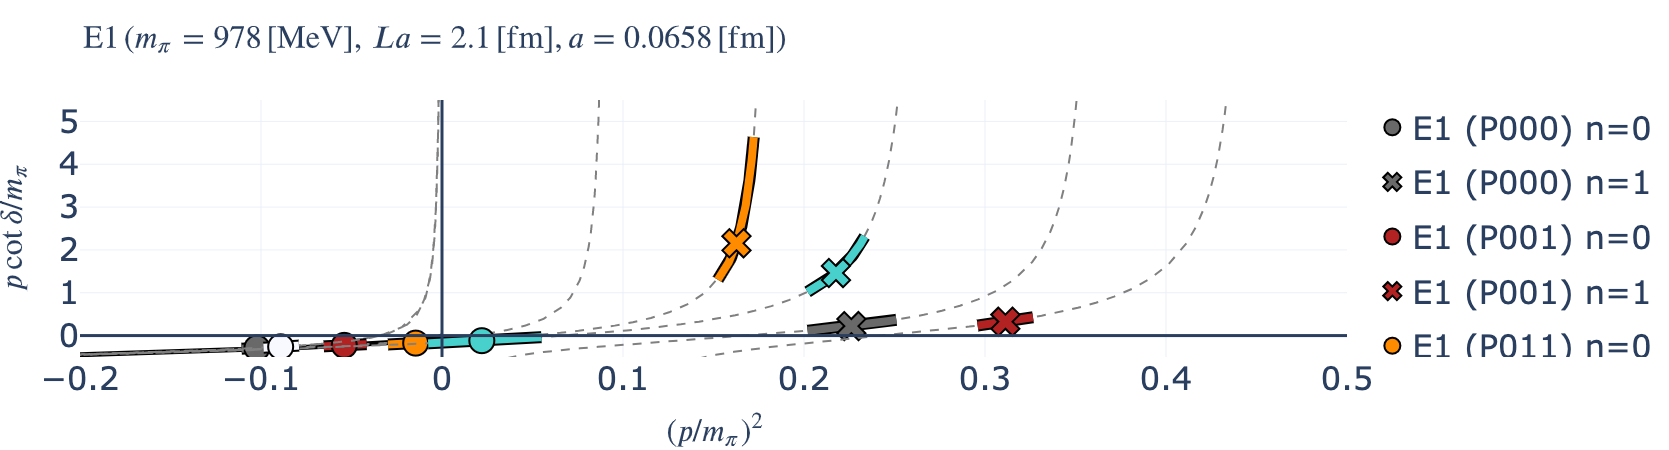

In [20]:
plotly_pcot_vs_p2('E1', (-0.2, 0.5), (-0.5, 5.5))

# all

In [21]:
color_list = sns.color_palette('tab10')

In [22]:
label_list

['N300', 'N202', 'H200', 'B450', 'H101', 'U103', 'A653', 'E5', 'E1']

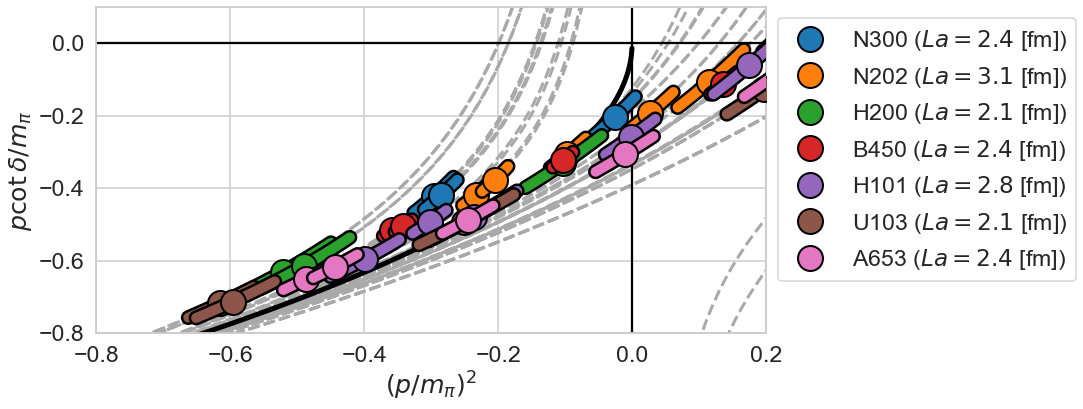

In [23]:
color_list = sns.color_palette('tab10')

xlim, ylim = (-0.8, 0.2), (-0.8, 0.1)

sym = 'o'
fig, ax = plt.subplots(figsize=(12, 6))

for ith, label in enumerate(label_list):
    if label in ['E5', 'E1']: continue
        
    c = color_list[ith]
    ax.plot([np.nan], [np.nan], sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=fr'{label} ($La = {L_fm_dic.get(label)}$ [fm])')

    for level in [0, 1]:

        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label='')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass

xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$')
fig.savefig(f'../figs/pcot_vs_p2/pcot_vs_p2_all_neg.png', bbox_inches='tight')

# fixed lattice spacing

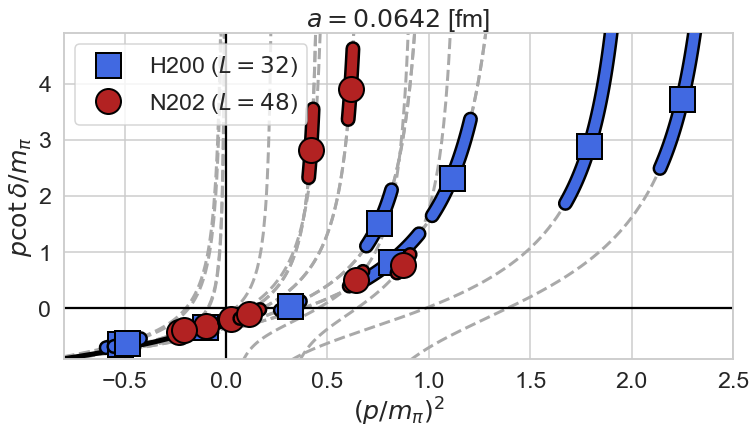

In [24]:
def comp_fixed_lattice_spacing(label_list, xlim, ylim, fig_suffix):
    fig, ax = plt.subplots(figsize=(12, 6))

    for label, c, sym in zip(label_list, ['royalblue', 'firebrick'], ['s', 'o']):
        ax.plot([np.nan], [np.nan], sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=fr'{label} ($L = {L_dic.get(label)}$)')

        for level in [0, 1]:

            for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
                try:
                    ld = ld_dic[(label, frame, level)]

                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                    ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label='')
                    ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


                except:
                    pass

    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left')
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'$a = {lat_unit_dic.get(label)}$ [fm]')
    fig.savefig(f'../figs/pcot_vs_p2/pcot_vs_p2_{fig_suffix}.png', bbox_inches='tight')
        
comp_fixed_lattice_spacing(['H200', 'N202'], xlim=xlim0, ylim=ylim0, fig_suffix='lat_spacing_00642fm')

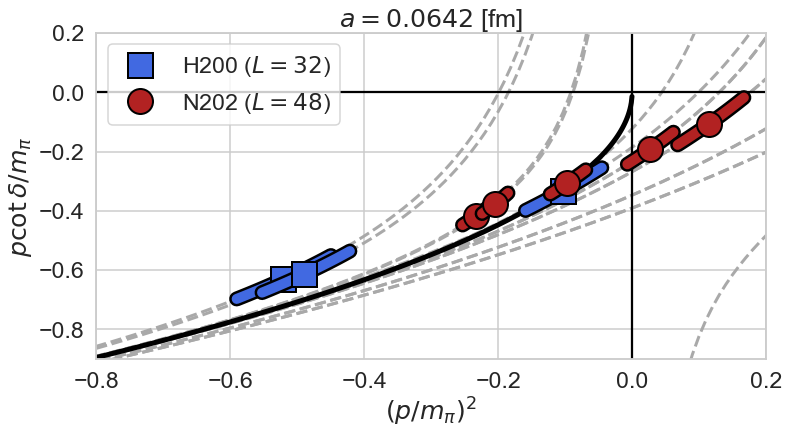

In [25]:
comp_fixed_lattice_spacing(['H200', 'N202'], xlim=(-0.8, 0.2), ylim=(-0.9, 0.2), fig_suffix='lat_spacing_00642fm_neg')

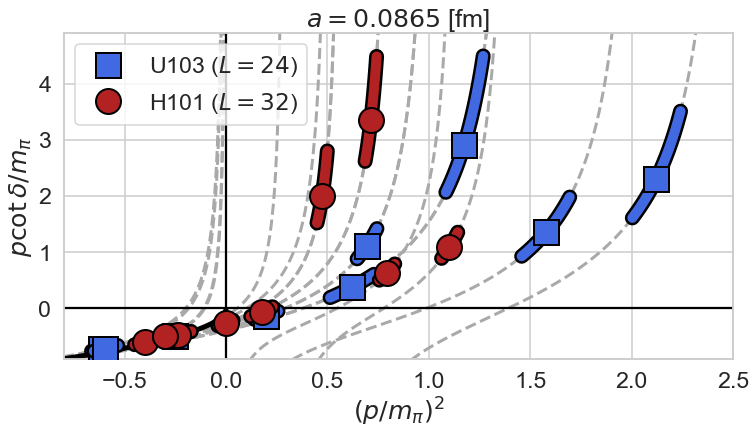

In [26]:
comp_fixed_lattice_spacing(['U103', 'H101'], xlim=xlim0, ylim=ylim0, fig_suffix='lat_spacing_00865fm')

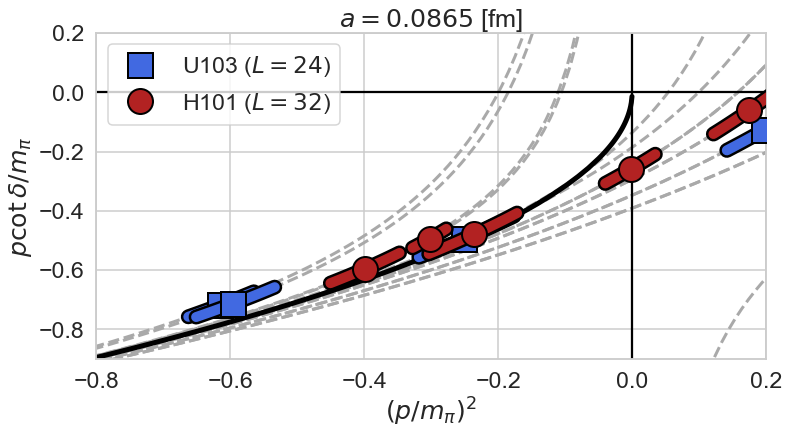

In [27]:
comp_fixed_lattice_spacing(['U103', 'H101'], xlim=(-0.8, 0.2), ylim=(-0.9, 0.2), fig_suffix='lat_spacing_00865fm_neg')

# fixed volume

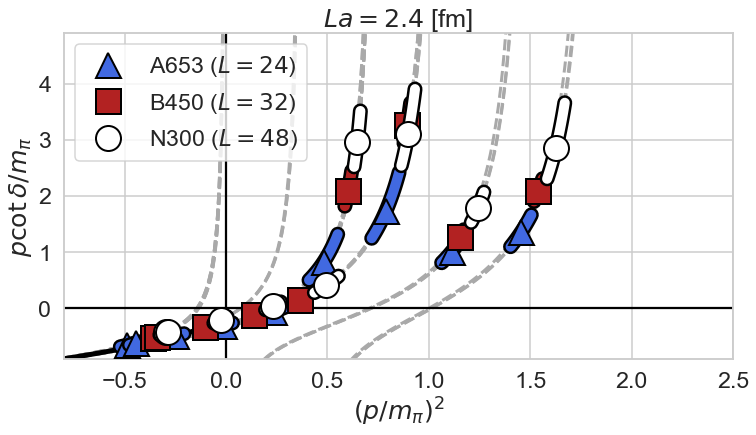

In [28]:
def comp_fixed_volume(label_list, xlim, ylim, fig_suffix):
    fig, ax = plt.subplots(figsize=(12, 6))

    for label, c, sym in zip(label_list, ['royalblue', 'firebrick', 'white'], ['^', 's', 'o']):
        ax.plot([np.nan], [np.nan], sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=fr'{label} ($L = {L_dic.get(label)}$)')

        for level in [0, 1]:

            for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
                try:
                    ld = ld_dic[(label, frame, level)]

                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                    ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label='')
                    ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


                except:
                    pass

    xbs = np.concatenate([np.linspace(xlim0[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left')
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'$La = {L_fm_dic.get(label)}$ [fm]')
    fig.savefig(f'../figs/pcot_vs_p2/pcot_vs_p2_{fig_suffix}.png', bbox_inches='tight')
        
comp_fixed_volume(['A653', 'B450', 'N300'], xlim=xlim0, ylim=ylim0, fig_suffix='La_2_4fm')

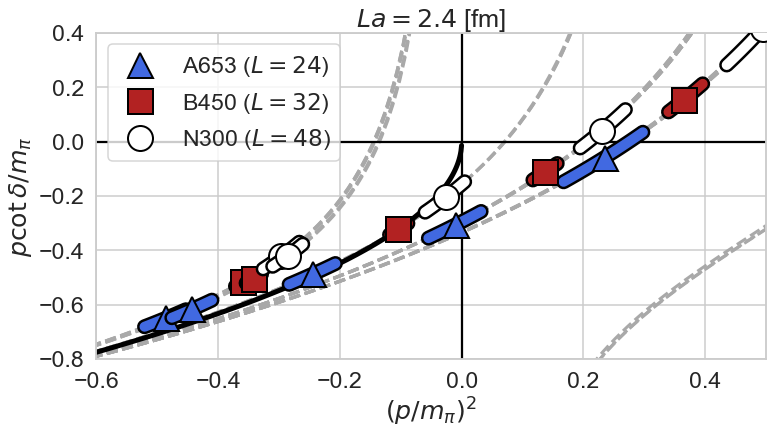

In [29]:
comp_fixed_volume(['A653', 'B450', 'N300'], xlim=(-0.6, 0.5), ylim=(-0.8, 0.4), fig_suffix='La_2_4fm_neg')

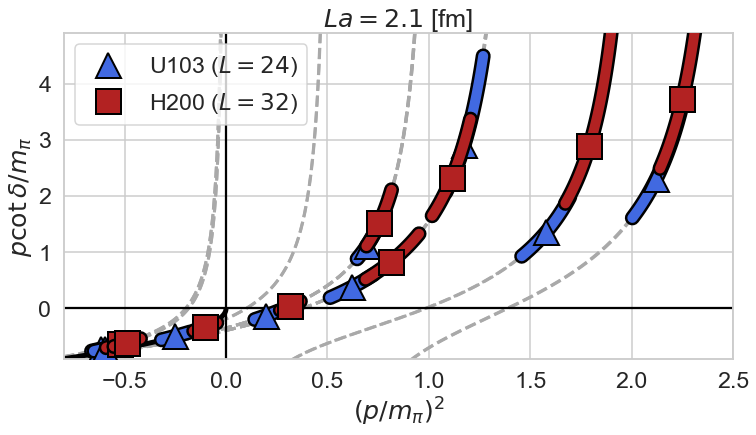

In [30]:
comp_fixed_volume(['U103', 'H200'], xlim=xlim0, ylim=ylim0, fig_suffix='La_2_2fm')

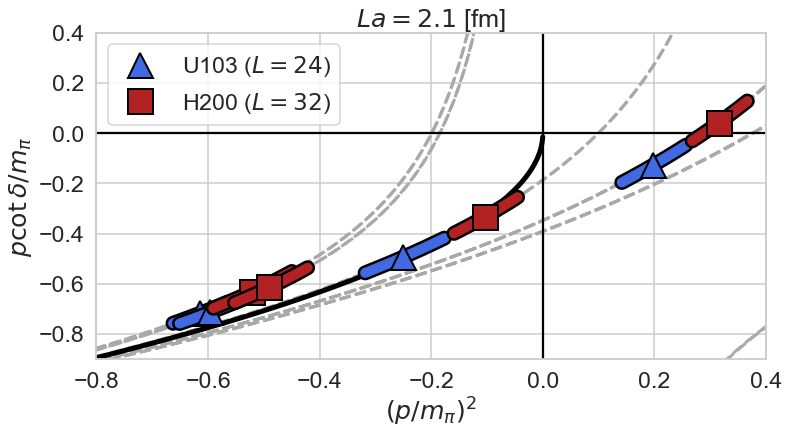

In [35]:
comp_fixed_volume(['U103', 'H200'], xlim=(-0.8, 0.4), ylim=(-0.9, 0.4), fig_suffix='La_2_2fm_neg')

# p-square vs binding energy

In [36]:
# approx. values
m_pi = 420 # MeV
m_B = 1200 # MeV

In [37]:
ls ../figs

SU3_ensembles.png  energy_levels/     pcot_vs_p2/


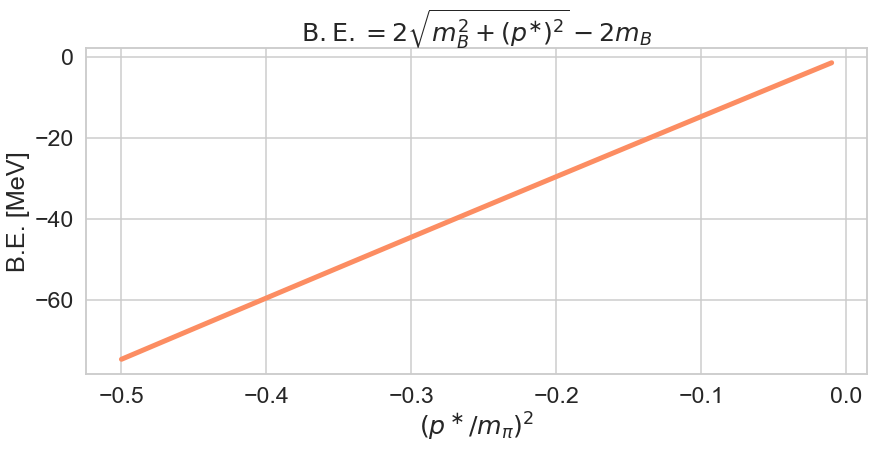

In [38]:
fig, ax = plt.subplots()

p_mpi_2 = np.linspace(-0.5, -0.01)
BE = 2 * np.sqrt(m_B**2 + p_mpi_2 * m_pi**2) - 2 * m_B

ax.plot(p_mpi_2, BE, lw=5, color='C1')

ax.set(ylabel='B.E. [MeV]', xlabel=r'$(p^\ast/m_\pi)^2$',
      title=r'$\mathrm{B.E.} = 2\sqrt{m_B^2 + (p^{\ast})^2} - 2 m_B$')

fig.savefig('BE_vs_p_square.png', bbox_inches='tight')

# ERE fitting

In [234]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [235]:
np.arange(10)[1:-1]

array([1, 2, 3, 4, 5, 6, 7, 8])

In [238]:
def check_ERE_intersection(label, xlim, ylim, ere_prm):
    ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2

    color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1,-2e-4)])

    fig = go.Figure()

    fig.add_hline(y=0, line_width=3)
    fig.add_vline(x=0, line_width=3)

    fig.add_trace(
        go.Scatter(x=xbs, y=-np.sqrt(-xbs), mode='lines',
                  line=dict(color='black', width=5), name='bound state condition', showlegend=False)
    )
    
    chisq = 0

    for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
        c = color_list.get(frame)
        level = 0
        try:
            ld = ld_dic[(label, frame, level)]

            sym={0:'circle', 1:'x', 2:'triangle-up'}[level]

            lbl = f'{label} ({frame}) n={level}'

            xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
            ymsk = (ys > ylim[0]) & (ys < ylim[1])
            ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

            intersect = lambda k2: ere(k2) - ll(k2)
            sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

            fig.add_traces(
                [
                    go.Scatter(x=ld.get('k2mpi2_ref'), y=ld.get('kcot_mpi_ref'), mode='lines',
                                    line=dict(dash='dash', color='gray', width=2), legendgroup=lbl, name='FV constraints', showlegend=False,
                                   hovertemplate='(%{x:.3f}, %{y:.3f})'),
                    go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                              line=dict(color='black', width=12), legendgroup=lbl, name='95CI',
                              hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                    go.Scatter(x=ld.get('k2mpi2s')[2:-2], y=ld.get('kcot_mpis')[2:-2], mode='lines',
                              line=dict(color=c, width=8), legendgroup=lbl, name='95CI',
                              hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                    go.Scatter(x=[ld.get('k2mpi2')], y=[ld.get('kcot_mpi')], mode='markers',
                               hovertemplate=lbl+'<br>(%{x:.3f}, %{y:.3f})', showlegend=True,
                                marker=dict(color=c, size=25, symbol=sym,
                                           line=dict(width=2, color='black')), legendgroup=lbl, name=lbl)
                ]
            )
            if sol.success:
                assert len(sol.x) == 1
                if sol.x[0] < ld.get('k2mpi2'):
                    chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
                else:
                    chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2

                fig.add_trace(go.Scatter(x=sol.x, y=ere(sol.x), mode='markers', 
                                         marker=dict(color='royalblue', size=25, symbol='x',
                                                    line=dict(width=3, color='white')), showlegend=False, legendgroup=lbl, name='intersect'))
            else:
                chisq = np.nan
        except:
            pass

    xls = np.linspace(xlim[0], xlim[1])
    fig.add_trace(
        go.Scatter(x=xls, y=ere(xls), mode='lines', line=dict(color='royalblue', width=5), name=f'ERE chi square = {chisq:.2f}')
    )
    
    fig.update_layout(
        title=f'$\LARGE{{\mathrm{{{label}}} \ (m_\pi = {pion_mass_dic.get(label)} \ [\mathrm{{MeV}}], \ La = {L_fm_dic.get(label)} \ [\mathrm{{fm}}], a = {lat_unit_dic.get(label)} \ [\mathrm{{fm}}])}}$',
        xaxis_title='$\LARGE{(p/m_\pi)^2}$', 
                     yaxis_title='$\LARGE{p\cot\delta/m_\pi}$',
                     xaxis_range=xlim, yaxis_range=ylim,
                     font=dict(size=32))
    return fig

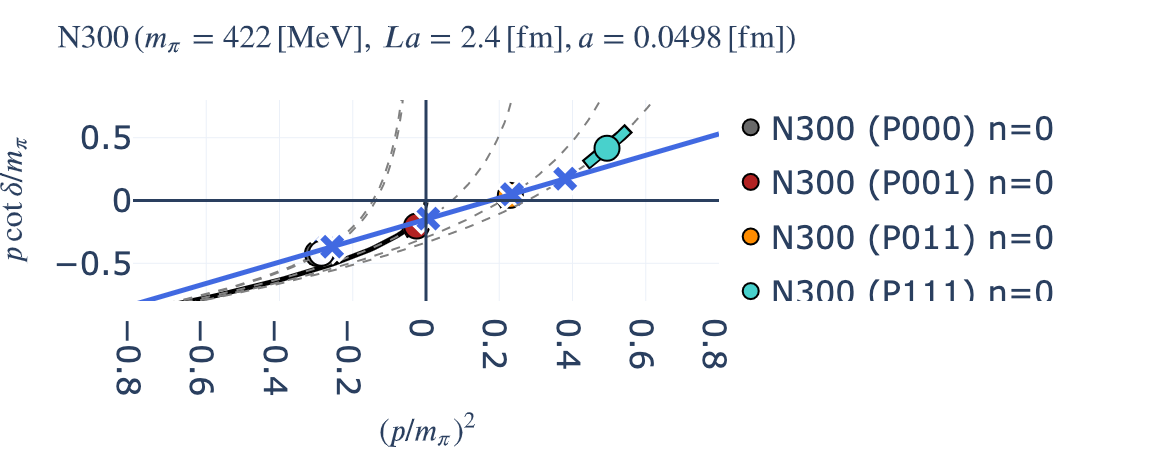

In [239]:
xlim, ylim = (-0.8, 0.8), (-0.8, 0.8)
label = 'N300'
xlim, ylim = (-0.8, 0.8), (-0.8, 0.8)
ere_prm = (-0.15, 1.7)
check_ERE_intersection(label, xlim, ylim, ere_prm)

In [301]:
class ERE_fitting(object):
    def __init__(self, label, xlim, ylim):
        """
        label : ex. 'N300'
        xlim : (-xmin, xmax)
        ylim : (-ymin, ymax)
        """
        self.label = label
        self.xlim = xlim
        self.ylim = ylim
    
    
    def check_ERE_intersection(self, ere_prm):
        """
        ere_prm : [1/a0, reff] in pion mass unit
        """
        ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2

        color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

        xbs = np.concatenate([np.linspace(self.xlim[0], -0.5e-1), np.linspace(-0.5e-1,-2e-4)])

        fig = go.Figure()

        fig.add_hline(y=0, line_width=3)
        fig.add_vline(x=0, line_width=3)

        fig.add_trace(
            go.Scatter(x=xbs, y=-np.sqrt(-xbs), mode='lines',
                      line=dict(color='black', width=5), name='bound state condition', showlegend=False)
        )

        chisq = 0

        for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
            c = color_list.get(frame)
            level = 0
            try:
                ld = ld_dic[(self.label, frame, level)]

                sym={0:'circle', 1:'x', 2:'triangle-up'}[level]

                lbl = f'{label} ({frame}) n={level}'

                xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
                ymsk = (ys > ylim[0]) & (ys < ylim[1])
                ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

                intersect = lambda k2: ere(k2) - ll(k2)
                sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

                fig.add_traces(
                    [
                        go.Scatter(x=ld.get('k2mpi2_ref'), y=ld.get('kcot_mpi_ref'), mode='lines',
                                        line=dict(dash='dash', color='gray', width=2), legendgroup=lbl, name='FV constraints', showlegend=False,
                                       hovertemplate='(%{x:.3f}, %{y:.3f})'),
                        go.Scatter(x=ld.get('k2mpi2s'), y=ld.get('kcot_mpis'), mode='lines',
                                  line=dict(color='black', width=12), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=ld.get('k2mpi2s')[2:-2], y=ld.get('kcot_mpis')[2:-2], mode='lines',
                                  line=dict(color=c, width=8), legendgroup=lbl, name='95CI',
                                  hovertemplate='(%{x:.3f}, %{y:.3f})', showlegend=False),
                        go.Scatter(x=[ld.get('k2mpi2')], y=[ld.get('kcot_mpi')], mode='markers',
                                   hovertemplate=lbl+'<br>(%{x:.3f}, %{y:.3f})', showlegend=True,
                                    marker=dict(color=c, size=25, symbol=sym,
                                               line=dict(width=2, color='black')), legendgroup=lbl, name=lbl)
                    ]
                )
                if sol.success:
                    assert len(sol.x) == 1
                    if sol.x[0] < ld.get('k2mpi2'):
                        chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
                    else:
                        chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2

                    fig.add_trace(go.Scatter(x=sol.x, y=ere(sol.x), mode='markers', 
                                             marker=dict(color='royalblue', size=25, symbol='x',
                                                        line=dict(width=3, color='white')), showlegend=False, legendgroup=lbl, name='intersect'))
                else:
                    chisq = np.nan
            except:
                pass

        xls = np.linspace(self.xlim[0], self.xlim[1])
        fig.add_trace(
            go.Scatter(x=xls, y=ere(xls), mode='lines', line=dict(color='royalblue', width=5), name=f'ERE chi square = {chisq:.2f}')
        )

        fig.update_layout(
            title=f'$\LARGE{{\mathrm{{{label}}} \ (m_\pi = {pion_mass_dic.get(label)} \ [\mathrm{{MeV}}], \ La = {L_fm_dic.get(label)} \ [\mathrm{{fm}}], a = {lat_unit_dic.get(label)} \ [\mathrm{{fm}}])}}$',
            xaxis_title='$\LARGE{(p/m_\pi)^2}$', 
                         yaxis_title='$\LARGE{p\cot\delta/m_\pi}$',
                         xaxis_range=self.xlim, yaxis_range=self.ylim,
                         font=dict(size=32))
        return fig
    
    def ERE_fit_and_plot(self, a0inv_lim, reff_lim, mesh_num=100):
        a0invs = np.linspace(a0inv_lim[0], a0inv_lim[1], mesh_num)
        reffs = np.linspace(reff_lim[0], reff_lim[1], mesh_num)
        
        chisq_ere = np.array([[self._calc_ERE_chisq([a0inv, reff]), a0inv, reff] for a0inv in a0invs for reff in reffs])
        
        
        fig, ax = plt.subplots()

        chisq_min, a0inv0, reff0 = ere_chisq[np.nanargmin(chisq_ere[:,0]),:]
        ax.plot(a0inv0, reff0, 'X', color='blue', mew=2, mec='white', ms=35,
               label=f'({a0inv0:.2f}, {reff0:.2f})')

        zz = np.copy(chisq_ere[:,:].reshape(mesh_num,mesh_num,3))
        mask = zz[:,:,0] > chisq_min + 2.3 # for 2 parameters
        zz[:,:,0][mask] = np.nan

        cb = ax.contourf(zz[:,:,1], zz[:,:,2], zz[:,:,0]-chisq_min, np.linspace(0, 0+2.3,100),
                        cmap=cm.inferno)
        cb.set_clim(0,2.3)
        fig.colorbar(cb, ticks=[0,0.5,1.0,1.5,2.0])

        BE_av = self.BE_from_ERE(a0inv0, reff0)
        mask2 = chisq_ere[:,0] <= chisq_min + 2.3
        BE_bs = self.BE_from_ERE(chisq_ere[mask2,1], chisq_ere[mask2,2])
        BE_lower, BE_upper = np.min(BE_bs), np.max(BE_bs)

        ax.set_title(rf'{label} ERE parameter $\chi^2 - \chi^2_\mathrm{{min}}(={chisq_min:.2f})$'
                    + '\n' + rf'$\mathrm{{B.E.}} = {BE_av:.2f}({BE_lower-BE_av:+.2f})({BE_upper-BE_av:+.2f})$ [MeV]')
        ax.set_xlabel(r'$(a_0m_\pi)^{-1}$')
        ax.set_ylabel(r'$r_\mathrm{eff}m_\pi$')
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        
        
        self.chisq_ere = chisq_ere
        
        
    def plot_k2_vs_kcot_with_ERE(self, xlim, ylim):
        ere_k2s = np.linspace(xlim[0], xlim[1])
        mask = self.chisq_ere[:,0] <= np.nanmin(self.chisq_ere[:,0]) + 2.3
        ere_upper = []
        ere_lower = []
        allowed_a0invs = self.chisq_ere[mask,1]
        allowed_reffs = self.chisq_ere[mask,2]
        ere_t = lambda p0, p1, k2: p0 + 0.5*p1*k2

        for k2 in ere_k2s:
            ere_upper.append(np.max(ere_t(allowed_a0invs, allowed_reffs, k2)))
            ere_lower.append(np.min(ere_t(allowed_a0invs, allowed_reffs, k2)))

        
        color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}


        fig, ax = plt.subplots(figsize=(12,6))

        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            c = color_list.get(frame)
            for level in [0, 1]:
                try:
                    ld = ld_dic[(self.label, frame, level)]

                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                    ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                    sym = {0: 'o', 1: 'X'}[level]
                    ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, 
                            label=f'{self.label} ({frame}) {level}')
                    if level == 0:
                        ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


                except:
                    pass

        ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3)
        ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
        ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


        xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
        ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

        ax.legend(loc='upper left', bbox_to_anchor=(1,1))
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')
        ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
              title=rf'{self.label} ($m_\pi = {pion_mass_dic.get(self.label)}$ [MeV], $La = {L_fm_dic.get(self.label)}$ [fm], $a = {lat_unit_dic.get(self.label)}$ [fm])')
#    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2_neg.png', bbox_inches='tight') # , transparent=True)
        
    
    def _calc_ERE_chisq(self, ere_prm):
        ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2

        chisq = 0

        for frame in ['P000', 'P001', 'P011', 'P111' ,'P002']:
            level = 0
            try:
                ld = ld_dic[(self.label, frame, level)]

                xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
                ymsk = (ys > self.ylim[0]) & (ys < self.ylim[1])
                ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

                intersect = lambda k2: ere(k2) - ll(k2)
                sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

                if sol.success:
                    assert len(sol.x) == 1
                    if sol.x[0] < ld.get('k2mpi2'):
                        chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
                    else:
                        chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2
                else:
                    chisq = np.nan
            except:
                pass

        return chisq
    

    def BE_from_ERE(self, a0inv, reff):
        k2ast = (-2*(reff*a0inv + 1) + 2 * np.sqrt((reff*a0inv+1)**2 - reff**2*a0inv**2))/(reff**2)

        return  - (
            2 * np.sqrt(k2ast*pion_mass_dic.get(self.label)**2 + (baryon_mass_dic.get(self.label)*1e3)**2) 
            - 2 * baryon_mass_dic.get(self.label)*1e3
        )

In [302]:
label = 'N300'
xlim = (-0.8, 0.8)
ylim = (-0.8, 0.8)
ef = ERE_fitting(label, xlim, ylim)

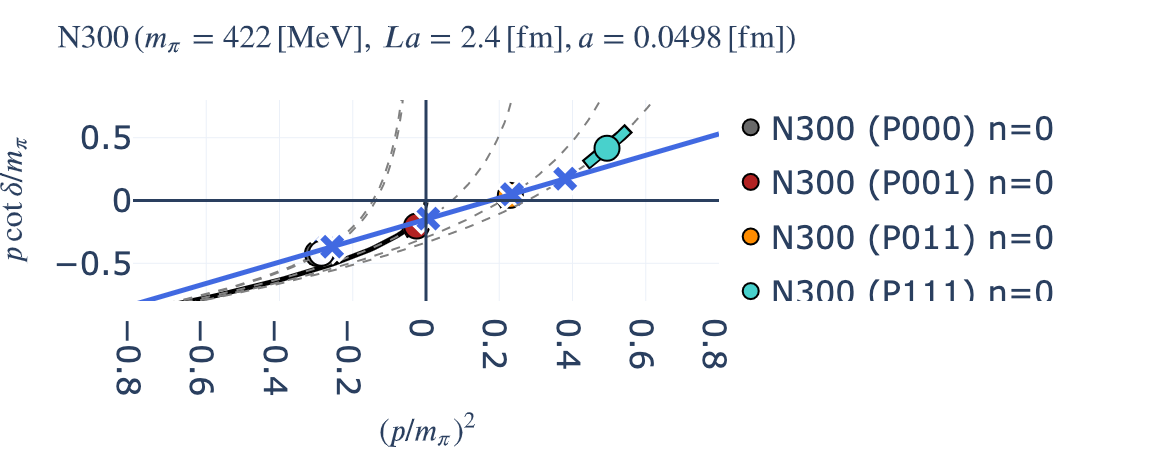

In [303]:
ere_prm = (-0.15, 1.7)
ef.check_ERE_intersection(ere_prm)

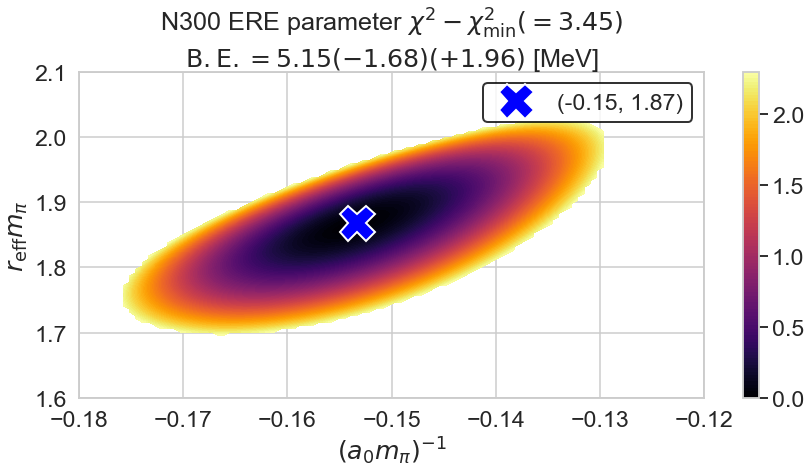

In [304]:
ef.ERE_fit_and_plot((-0.18, -0.12), (1.6, 2.1), mesh_num=100)

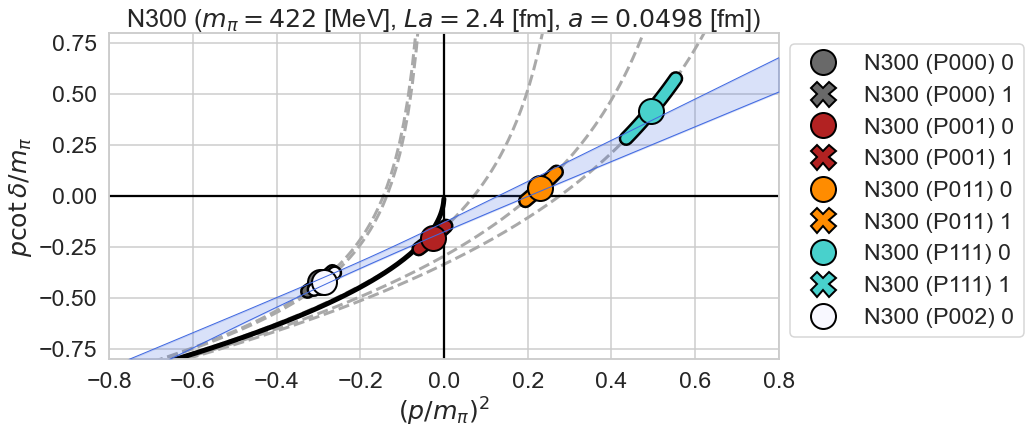

In [305]:
ef.plot_k2_vs_kcot_with_ERE(xlim, ylim)

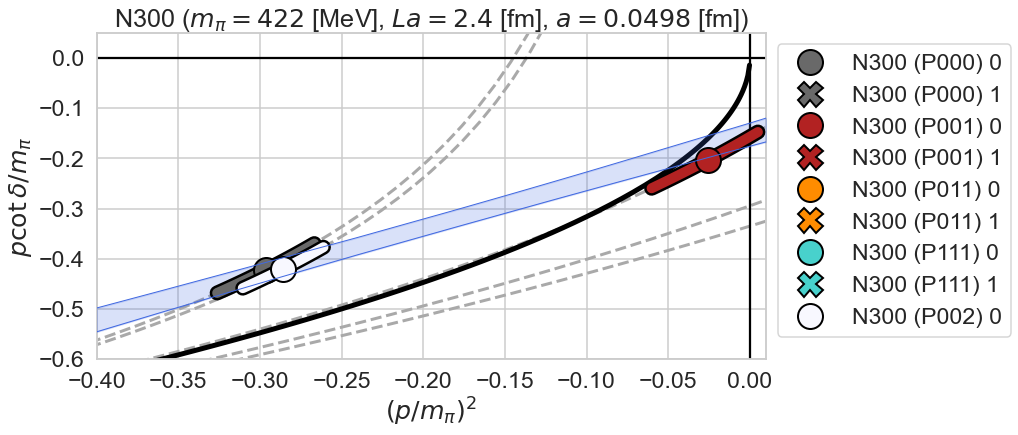

In [307]:
ef.plot_k2_vs_kcot_with_ERE((-0.4, 0.01), (-0.6,0.05))